### Agent Assembly Line

What if the challenge isn’t the complexity of one task, but the sheer volume of a continuous stream of tasks?

For many industrial applications, the most critical metric isn’t how fast you can process one item, but how many items you can process per hour.

<p align="center">
  <img src="../../figures/agent_assembly_line.png" width="1200">
</p>

This pattern shifts our focus from minimizing latency to maximizing throughput.

Instead of one monolithic agent processing items one by one from start to finish, we break the process into a sequence of specialized stations. As soon as Station A finishes its job on Item 1, it passes the item to Station B and immediately starts working on Item 2. All stations work in parallel, but on different items in the stream.

We will build a three-stage pipeline to process a batch of product reviews. Our goal is to demonstrate, through careful timing analysis, how this pipelined parallelism dramatically increases the number of reviews processed per second compared to a traditional, sequential approach.

In [92]:
from dotenv import load_dotenv
load_dotenv()

True

First, we need to define the data structures that will represent a review as it moves through our assembly line, being progressively enriched at each station.

In [1]:
from pydantic import BaseModel, Field
from typing import List, Literal, Optional


class TriageResult(BaseModel):
    """The structured output of the initial Triage station."""
    category: Literal["Feedback", "Bug Report", "Support Request", "Irrelevant"] = Field(description="The category of the review.")

class Summary(BaseModel):
    """The structured output of the Summarization station."""
    summary: str = Field(description="A one-sentence summary of the key feedback in the review.")

class ExtractedData(BaseModel):
    """The structured output of the Data Extraction station."""
    product_mentioned: str = Field(description="The specific product the review is about.")
    sentiment: Literal["Positive", "Negative", "Neutral"] = Field(description="The overall sentiment of the review.")
    key_feature: str = Field(description="The main feature or aspect discussed in the review.")

class ProcessedReview(BaseModel):
    """The final, fully processed review object that accumulates data from all stations."""
    original_review: str
    category: str
    summary: Optional[str] = None
    extracted_data: Optional[ExtractedData] = None

These Pydantic models are the “standardized shipping containers” for our assembly line. The ProcessedReview object is the central data carrier. It is created at the first station (Triage) and then progressively enriched with a summary and extracted_data as it moves through the subsequent stations. This ensures a consistent data contract between each stage of our pipeline.

### Defining the Pipeline Agent Prompts
Each agent in our assembly line gets a highly specialized prompt for its specific task.

In [3]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser

triage_parser = JsonOutputParser(
    pydantic_object=TriageResult
)

triage_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a Triage Specialist. Your job is to read a user review and categorize it into one of four categories: Feedback, Bug Report, Support Request, or Irrelevant.\n\n{format_instructions}"),
    ("human", "Please categorize the following review:\n\n---\n{review_text}\n---")
]).partial(format_instructions=triage_parser.get_format_instructions())

summarizer_parser = JsonOutputParser(
    pydantic_object=Summary
)

summarizer_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a Summarization Specialist. Your job is to read a user review and write a clear, one-sentence summary of its main point.\n\n{format_instructions}"),
    ("human", "Please summarize the following review:\n\n---\n{review_text}\n---")
]).partial(format_instructions=summarizer_parser.get_format_instructions())

extractor_parser = JsonOutputParser(
    pydantic_object=ExtractedData
)

extractor_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a Data Extraction Specialist. Your job is to read a review summary and extract the product mentioned, the sentiment, and the key feature discussed.\n\n{format_instructions}"),
    ("human", "Please extract structured data from the following summary:\n\n---\n{summary_text}\n---")
]).partial(format_instructions=extractor_parser.get_format_instructions())

/Users/rachneet/projects/agents_experimental/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Creating the Agent Chains
We'll package our prompts and the structured-output LLM into reusable LangChain Expression Language (LCEL) chains.

In [60]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

llm = ChatHuggingFace(
    llm=HuggingFaceEndpoint(
        model="moonshotai/Kimi-K2-Instruct"
    )
)

In [61]:
triage_chain = triage_prompt | llm | triage_parser
summarizer_chain = summarizer_prompt | llm | summarizer_parser
extractor_chain = extractor_prompt | llm | extractor_parser

### Defining the Graph State
The state will hold the initial batch of reviews and the final list of fully processed reviews.

In [62]:
from typing import TypedDict, Annotated, List
from langgraph.graph.message import add_messages

class PipelineState(TypedDict):
    # 'initial_reviews' holds the incoming batch of raw review strings.
    initial_reviews: List[str]
    # 'processed_reviews' is the list of ProcessedReview objects that are built up as they move through the pipeline.
    processed_reviews: List[ProcessedReview]
    performance_log: Annotated[List[str], add_messages]

### Defining the Graph Nodes (The Assembly Stations)
Each node represents a station on our assembly line. We will use Python's ThreadPoolExecutor to achieve true parallelism within each node, allowing each agent to process multiple items concurrently.

Now, we define the nodes for each “station” on our assembly line. The key implementation detail is that each node uses a ThreadPoolExecutor to process all the items assigned to its stage in parallel.

In [63]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
from tqdm import tqdm

MAX_WORKERS = 4  # This controls the degree of parallelism within each station.

# Station 1: Triage Node
def triage_node(state: PipelineState):
    """The first station: categorizes all initial reviews in parallel."""
    print(f"--- [Station 1: Triage] Processing {len(state['initial_reviews'])} reviews... ---")
    start_time = time.time()
    
    triaged_reviews = []
    # We use a ThreadPoolExecutor to make parallel LLM calls for each review.
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # We create a future for each review to be triaged.
        future_to_review = {executor.submit(triage_chain.invoke, {"review_text": review}): review for review in state['initial_reviews']}
        for future in tqdm(as_completed(future_to_review), total=len(state['initial_reviews']), desc="Triage Progress"):
            original_review = future_to_review[future]
            try:
                result = future.result()
                # We create the initial ProcessedReview object here.
                triaged_reviews.append(ProcessedReview(original_review=original_review, category=result["category"]))
            except Exception as exc:
                print(f'Review generated an exception: {exc}')
    
    execution_time = time.time() - start_time
    log = f"[Triage] Processed {len(state['initial_reviews'])} reviews in {execution_time:.2f}s."
    print(log)
    
    # The output of this node is the initial list of processed reviews.
    return {"processed_reviews": triaged_reviews, "performance_log": [log]}

Instead of looping through the reviews one by one, it submits all of them to the triage_chain at once. The as_completed iterator then yields results as they finish, allowing us to build our list of triaged_reviews efficiently. This make sure that the time taken by this station is determined by the handful of slowest LLM calls, not the sum of all of them.

The subsequent nodes, summarize_node and extract_data_node, follow the same parallel processing pattern. They first filter for the items they are responsible for and then process them concurrently.

In [ ]:
# Station 2: Summarize Node
def summarize_node(state: PipelineState):
    """The second station: filters for 'Feedback' reviews and summarizes them in parallel."""
    # This station only operates on reviews categorized as 'Feedback'.
    feedback_reviews = [r for r in state['processed_reviews'] if r.category == "Feedback"]
    if not feedback_reviews:
        print("--- [Station 2: Summarizer] No feedback reviews to process. Skipping. ---")
        return {}
    
    print(f"--- [Station 2: Summarizer] Processing {len(feedback_reviews)} feedback reviews... ---")
    start_time = time.time()
    
    # We use a map to easily update the reviews in place.
    review_map = {r.original_review: r for r in state['processed_reviews']}
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        future_to_review = {executor.submit(summarizer_chain.invoke, {"review_text": r.original_review}): r for r in feedback_reviews}
        for future in tqdm(as_completed(future_to_review), total=len(feedback_reviews), desc="Summarizer Progress"):
            original_review_obj = future_to_review[future]
            try:
                result = future.result()
                # We find the original review object in our map and enrich it with the summary.
                # but pydantic model is immutable
                updated_review = original_review_obj.model_copy(update={"summary": result["summary"]})
                review_map[original_review_obj.original_review] = updated_review
                # review_map[original_review_obj.original_review]["summary"] = result["summary"]
            except Exception as exc:
                print(f'Review generated an exception: {exc}')
    
    execution_time = time.time() - start_time
    log = f"[Summarizer] Processed {len(feedback_reviews)} reviews in {execution_time:.2f}s."
    print(log)
    
    # We return the full, updated list of reviews.
    return {"processed_reviews": list(review_map.values()), "performance_log": [log]}

In [76]:
# Station 3: Extract Data Node
def extract_data_node(state: PipelineState):
    """The final station: extracts structured data from summarized reviews in parallel."""
    # This station only operates on reviews that have a summary.
    summarized_reviews = [r for r in state['processed_reviews'] if r.summary is not None]
    if not summarized_reviews:
        print("--- [Station 3: Extractor] No summarized reviews to process. Skipping. ---")
        return {}
        
    print(f"--- [Station 3: Extractor] Processing {len(summarized_reviews)} summarized reviews... ---")
    start_time = time.time()
    
    review_map = {r.original_review: r for r in state['processed_reviews']}
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        future_to_review = {executor.submit(extractor_chain.invoke, {"summary_text": r.summary}): r for r in summarized_reviews}
        for future in tqdm(as_completed(future_to_review), total=len(summarized_reviews), desc="Extractor Progress"):
            original_review_obj = future_to_review[future]
            try:
                result = future.result()
                # We enrich the review object one last time with the extracted data.
                # review_map[original_review_obj.original_review]["extracted_data"] = result
                extracted_data = ExtractedData(**result) if isinstance(result, dict) else result
                updated_review = original_review_obj.model_copy(update={"extracted_data": extracted_data})
                review_map[original_review_obj.original_review] = updated_review

            except Exception as exc:
                print(f'Review generated an exception: {exc}')
    
    execution_time = time.time() - start_time
    log = f"[Extractor] Processed {len(summarized_reviews)} reviews in {execution_time:.2f}s."
    print(log)
    
    return {"processed_reviews": list(review_map.values()), "performance_log": [log]}

In [77]:
from langgraph.graph import StateGraph, END

# Initialize the graph.
workflow = StateGraph(PipelineState)

# Add the three stations as nodes.
workflow.add_node("triage", triage_node)
workflow.add_node("summarize", summarize_node)
workflow.add_node("extract_data", extract_data_node)

# Define the linear flow of the assembly line.
workflow.set_entry_point("triage")
workflow.add_edge("triage", "summarize")
workflow.add_edge("summarize", "extract_data")
workflow.add_edge("extract_data", END)

# Compile the graph.
app = workflow.compile()

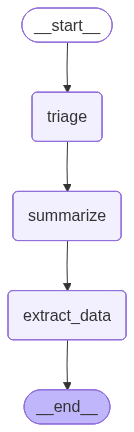

In [78]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

### Running the Pipeline and Analyzing Throughput
We'll create a batch of 10 sample reviews and run them through our assembly line. We'll pay close attention to the execution time of each stage.

In [79]:
sample_reviews = [
    "The Aura Smart Ring's battery life is incredible, easily lasts a week! Best sleep tracker I've ever used.", # Feedback
    "My QuantumLeap processor arrived with a bent pin, and the box was crushed. I need a replacement ASAP.", # Support Request
    "Love the new Smart Mug, but the app keeps crashing on my Android phone whenever I try to set a custom temperature.", # Bug Report
    "The titanium finish on the Aura Ring feels so premium. It's lightweight and looks amazing.", # Feedback
    "I think I was overcharged for my last order (A123). Can someone please check my invoice?", # Support Request
    "The personalized energy suggestions from the Smart Mug are surprisingly accurate. A great feature!", # Feedback
    "This is not a product review, I just wanted to say your website is very well designed.", # Irrelevant
    "The QuantumLeap is fast, but it runs way too hot. The fan noise is a real problem under load.", # Feedback
    "The app for the Aura Ring fails to sync my sleep data about half the time. I have to restart my phone to fix it.", # Bug Report
    "I wish the Smart Mug came in more colors. A matte black option would be perfect.", # Feedback
]

In [80]:
inputs = {
    "initial_reviews": sample_reviews,
    "processed_reviews": []
}

final_state = None
for output in app.stream(inputs, stream_mode="values"):
    final_state = output

--- [Station 1: Triage] Processing 10 reviews... ---


Triage Progress: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


[Triage] Processed 10 reviews in 4.79s.
--- [Station 2: Summarizer] Processing 6 feedback reviews... ---


Summarizer Progress:  33%|███▎      | 2/6 [00:01<00:03,  1.30it/s]

original_review="The titanium finish on the Aura Ring feels so premium. It's lightweight and looks amazing." category='Feedback' summary=None extracted_data=None
{'summary': "The reviewer loves the Aura Ring's premium titanium finish, noting its lightweight feel and attractive appearance."}
original_review="The Aura Smart Ring's battery life is incredible, easily lasts a week! Best sleep tracker I've ever used." category='Feedback' summary=None extracted_data=None
{'summary': 'The reviewer praises the Aura Smart Ring for its exceptional week-long battery life and excellent sleep tracking capabilities.'}


Summarizer Progress:  67%|██████▋   | 4/6 [00:02<00:00,  2.81it/s]

original_review='This is not a product review, I just wanted to say your website is very well designed.' category='Feedback' summary=None extracted_data=None
{'summary': "The reviewer praised the website's design rather than reviewing the product itself."}
original_review='The QuantumLeap is fast, but it runs way too hot. The fan noise is a real problem under load.' category='Feedback' summary=None extracted_data=None
{'summary': 'While the QuantumLeap is fast, its excessive heat and loud fan noise under load are major drawbacks.'}


Summarizer Progress:  83%|████████▎ | 5/6 [00:03<00:00,  1.57it/s]

original_review='The personalized energy suggestions from the Smart Mug are surprisingly accurate. A great feature!' category='Feedback' summary=None extracted_data=None
{'summary': "The reviewer praises the Smart Mug's personalized energy suggestions for being surprisingly accurate and a great feature.}"}


Summarizer Progress: 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]


original_review='I wish the Smart Mug came in more colors. A matte black option would be perfect.' category='Feedback' summary=None extracted_data=None
{'summary': 'The reviewer wants the Smart Mug to be available in additional colors, specifically a matte black option.}'}
[Summarizer] Processed 6 reviews in 4.13s.
--- [Station 3: Extractor] Processing 6 summarized reviews... ---


Extractor Progress: 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]

[Extractor] Processed 6 reviews in 4.80s.


In [84]:
import json
print("="*60)
print("                FINAL PROCESSED DATA (Sample)")
print("="*60)

for i in [0, 1]: # Print a sample of two processed reviews
    print(json.dumps(final_state['processed_reviews'][i], indent=4, default=lambda o: o.model_dump() if hasattr(o, 'dict') else o))
    print("-"*60)

                FINAL PROCESSED DATA (Sample)
{
    "original_review": "My QuantumLeap processor arrived with a bent pin, and the box was crushed. I need a replacement ASAP.",
    "category": "Support Request",
    "summary": null,
    "extracted_data": null
}
------------------------------------------------------------
{
    "original_review": "The Aura Smart Ring's battery life is incredible, easily lasts a week! Best sleep tracker I've ever used.",
    "category": "Feedback",
    "summary": "The reviewer praises the Aura Smart Ring for its exceptional week-long battery life and excellent sleep tracking capabilities.",
    "extracted_data": {
        "product_mentioned": "Aura Smart Ring",
        "sentiment": "Positive",
        "key_feature": "week-long battery life and excellent sleep tracking capabilities"
    }
}
------------------------------------------------------------


### Analysis

In [90]:
logs = final_state["performance_log"]
triage_time = float(logs[0].content.rstrip("s.").split(" ")[-1])
summarize_time = float(logs[1].content.rstrip("s.").split(" ")[-1])
extract_time = float(logs[2].content.rstrip("s.").split(" ")[-1])


print(triage_time, summarize_time, extract_time)
num_reviews = len(final_state["processed_reviews"])
print(num_reviews)

4.79 4.13 4.8
10


In [91]:
# The total time for our pipelined workflow is the sum of the time for each stage to process the entire batch.
pipelined_total_time = triage_time + summarize_time + extract_time

# Throughput is the total number of items processed divided by the total time.
pipelined_throughput = num_reviews / pipelined_total_time

# Now, we simulate a sequential, monolithic agent.
# First, estimate the average time it takes for one item to pass through one stage.
avg_time_per_stage_per_review = (triage_time + summarize_time + extract_time) / num_reviews

# The total latency for a single review to be processed from start to finish is the time for all three stages.
total_latency_per_review = avg_time_per_stage_per_review * 3

# The total time for a sequential agent to process 10 reviews is 10 times the latency of one review.
sequential_total_time = total_latency_per_review * num_reviews
sequential_throughput = num_reviews / sequential_total_time

# Calculate the percentage increase in throughput.
throughput_increase = ((pipelined_throughput - sequential_throughput) / sequential_throughput) * 100

print("="*60)
print("                      PERFORMANCE ANALYSIS")
print("="*60)
print("\n--- Assembly Line (Pipelined) Workflow ---")
print(f"Total Time to Process {num_reviews} Reviews: {pipelined_total_time:.2f} seconds")
print(f"Calculated Throughput: {pipelined_throughput:.2f} reviews/second\n")
print("--- Monolithic (Sequential) Workflow (Simulated) ---")
print(f"Avg. Latency For One Review to Complete All Stages: {total_latency_per_review:.2f} seconds")
print(f"Simulated Total Time to Process {num_reviews} Reviews: {sequential_total_time:.2f} seconds")
print(f"Simulated Throughput: {sequential_throughput:.2f} reviews/second\n")
print("="*60)
print("                        CONCLUSION")
print("="*60)
print(f"Throughput Increase: {throughput_increase:.0f}%")

                      PERFORMANCE ANALYSIS

--- Assembly Line (Pipelined) Workflow ---
Total Time to Process 10 Reviews: 13.72 seconds
Calculated Throughput: 0.73 reviews/second

--- Monolithic (Sequential) Workflow (Simulated) ---
Avg. Latency For One Review to Complete All Stages: 4.12 seconds
Simulated Total Time to Process 10 Reviews: 41.16 seconds
Simulated Throughput: 0.24 reviews/second

                        CONCLUSION
Throughput Increase: 200%
